<a href="https://colab.research.google.com/github/tylerlum/ufc_automated_scoring_system/blob/main/UFC_automated_scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UFC Automated Scoring

The goal of this notebook is to:
* Read in stored, scraped UFC data and convert it into a dataset ready for ML models
* Train, test, and analyze ML models

Functional as of April 2021

## Read in stored data

In [1]:
import numpy as np
import pandas as pd

In [2]:
STORED_FIGHT_TABLE = pd.read_csv('FIGHT_TABLE_NUM_EVENTS_All_DATA_MODE_Summary_22-04-2021_11:08:22.csv')

In [3]:
STORED_FIGHT_TABLE

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,Fighter 0 Td %,Fighter 1 Td %,Fighter 0 Sub. att,Fighter 1 Sub. att,Fighter 0 Rev.,Fighter 1 Rev.,Fighter 0 Ctrl,Fighter 1 Ctrl,Fighter 0 Name,Fighter 1 Name,Fighter 0 Head,Fighter 1 Head,Fighter 0 Body,Fighter 1 Body,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground,Winner,Method
0,0,0,150,62,52.0,29.0,169,70,4,1,57.0,20.0,0,0,0,0,259.0,26.0,Robert Whittaker,Kelvin Gastelum,115,42,13,7,22,13,138,59,5,3,7,0,0,U-DEC
1,0,0,105,88,47.0,45.0,109,99,0,0,NaN,NaN,0,0,0,0,39.0,0.0,Andrei Arlovski,Chase Sherman,54,55,26,16,25,17,103,84,2,4,0,0,0,U-DEC
2,0,0,21,27,44.0,49.0,32,91,0,8,NaN,33.0,0,2,0,0,2.0,701.0,Abdul Razak Alhassan,Jacob Malkoun,11,24,9,2,1,1,14,18,5,3,2,6,1,U-DEC
3,0,1,66,55,58.0,46.0,84,72,3,0,60.0,0.0,1,0,0,0,386.0,38.0,Tracy Cortez,Justine Kish,40,30,19,8,7,17,39,50,7,4,20,1,0,S-DEC
4,0,0,90,80,46.0,47.0,90,82,0,4,NaN,44.0,0,0,0,0,3.0,141.0,Luis Pena,Alexander Munoz,74,40,12,20,4,20,88,77,2,3,0,0,0,S-DEC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5888,2,0,24,16,68.0,33.0,49,31,0,1,NaN,50.0,0,0,0,0,NaN,NaN,Pedro Rizzo,David Abbott,12,16,0,0,12,0,17,7,4,4,3,5,0,KO/TKO Punch
5889,0,0,19,24,55.0,55.0,95,145,1,2,11.0,100.0,0,2,0,1,NaN,NaN,Pat Miletich,Mikey Burnett,2,2,12,20,5,2,4,1,15,23,0,0,0,S-DEC
5890,0,0,14,13,35.0,19.0,30,15,3,0,60.0,NaN,5,0,1,0,NaN,NaN,Tsuyoshi Kohsaka,Pete Williams,7,6,4,7,3,0,11,12,0,1,3,0,0,U-DEC
5891,0,0,9,3,56.0,60.0,17,11,1,0,100.0,NaN,1,0,0,0,NaN,NaN,Ebenezer Fontes Braga,Jeremy Horn,6,0,1,3,2,0,2,0,5,3,2,0,0,SUB Guillotine Choke


In [4]:
# Clean dataset: Only decisions with clear winners
STORED_FIGHT_TABLE = STORED_FIGHT_TABLE[STORED_FIGHT_TABLE["Method"].str.contains("DEC")]
STORED_FIGHT_TABLE = STORED_FIGHT_TABLE[(STORED_FIGHT_TABLE["Winner"] == 1) | (STORED_FIGHT_TABLE["Winner"] == 0)]
STORED_FIGHT_TABLE

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,Fighter 0 Td %,Fighter 1 Td %,Fighter 0 Sub. att,Fighter 1 Sub. att,Fighter 0 Rev.,Fighter 1 Rev.,Fighter 0 Ctrl,Fighter 1 Ctrl,Fighter 0 Name,Fighter 1 Name,Fighter 0 Head,Fighter 1 Head,Fighter 0 Body,Fighter 1 Body,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground,Winner,Method
0,0,0,150,62,52.0,29.0,169,70,4,1,57.0,20.0,0,0,0,0,259.0,26.0,Robert Whittaker,Kelvin Gastelum,115,42,13,7,22,13,138,59,5,3,7,0,0,U-DEC
1,0,0,105,88,47.0,45.0,109,99,0,0,NaN,NaN,0,0,0,0,39.0,0.0,Andrei Arlovski,Chase Sherman,54,55,26,16,25,17,103,84,2,4,0,0,0,U-DEC
2,0,0,21,27,44.0,49.0,32,91,0,8,NaN,33.0,0,2,0,0,2.0,701.0,Abdul Razak Alhassan,Jacob Malkoun,11,24,9,2,1,1,14,18,5,3,2,6,1,U-DEC
3,0,1,66,55,58.0,46.0,84,72,3,0,60.0,0.0,1,0,0,0,386.0,38.0,Tracy Cortez,Justine Kish,40,30,19,8,7,17,39,50,7,4,20,1,0,S-DEC
4,0,0,90,80,46.0,47.0,90,82,0,4,NaN,44.0,0,0,0,0,3.0,141.0,Luis Pena,Alexander Munoz,74,40,12,20,4,20,88,77,2,3,0,0,0,S-DEC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5880,0,0,27,19,38.0,21.0,71,21,3,1,100.0,16.0,0,1,0,0,NaN,NaN,Pat Miletich,Jorge Patino,9,5,4,1,14,13,20,16,2,2,5,1,0,U-DEC
5881,0,0,16,25,55.0,47.0,29,58,0,2,NaN,33.0,0,0,0,0,NaN,NaN,Pedro Rizzo,Mark Coleman,9,23,0,0,7,2,15,7,1,0,0,18,0,S-DEC
5883,1,0,42,34,31.0,53.0,57,41,0,0,NaN,0.0,1,0,0,0,NaN,NaN,Mikey Burnett,Townsend Saunders,28,7,9,14,5,13,21,20,19,14,2,0,0,U-DEC
5889,0,0,19,24,55.0,55.0,95,145,1,2,11.0,100.0,0,2,0,1,NaN,NaN,Pat Miletich,Mikey Burnett,2,2,12,20,5,2,4,1,15,23,0,0,0,S-DEC


In [5]:
X = STORED_FIGHT_TABLE.drop(['Winner', 'Fighter 0 Name', 'Fighter 1 Name', 'Method'], axis=1).fillna(0)
y = STORED_FIGHT_TABLE[['Winner']]

In [6]:
X

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,Fighter 0 Td %,Fighter 1 Td %,Fighter 0 Sub. att,Fighter 1 Sub. att,Fighter 0 Rev.,Fighter 1 Rev.,Fighter 0 Ctrl,Fighter 1 Ctrl,Fighter 0 Head,Fighter 1 Head,Fighter 0 Body,Fighter 1 Body,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground
0,0,0,150,62,52.0,29.0,169,70,4,1,57.0,20.0,0,0,0,0,259.0,26.0,115,42,13,7,22,13,138,59,5,3,7,0
1,0,0,105,88,47.0,45.0,109,99,0,0,0.0,0.0,0,0,0,0,39.0,0.0,54,55,26,16,25,17,103,84,2,4,0,0
2,0,0,21,27,44.0,49.0,32,91,0,8,0.0,33.0,0,2,0,0,2.0,701.0,11,24,9,2,1,1,14,18,5,3,2,6
3,0,1,66,55,58.0,46.0,84,72,3,0,60.0,0.0,1,0,0,0,386.0,38.0,40,30,19,8,7,17,39,50,7,4,20,1
4,0,0,90,80,46.0,47.0,90,82,0,4,0.0,44.0,0,0,0,0,3.0,141.0,74,40,12,20,4,20,88,77,2,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5880,0,0,27,19,38.0,21.0,71,21,3,1,100.0,16.0,0,1,0,0,0.0,0.0,9,5,4,1,14,13,20,16,2,2,5,1
5881,0,0,16,25,55.0,47.0,29,58,0,2,0.0,33.0,0,0,0,0,0.0,0.0,9,23,0,0,7,2,15,7,1,0,0,18
5883,1,0,42,34,31.0,53.0,57,41,0,0,0.0,0.0,1,0,0,0,0.0,0.0,28,7,9,14,5,13,21,20,19,14,2,0
5889,0,0,19,24,55.0,55.0,95,145,1,2,11.0,100.0,0,2,0,1,0.0,0.0,2,2,12,20,5,2,4,1,15,23,0,0


In [7]:
y

,Winner
0,0
1,0
2,1
3,0
4,0
...,...
5880,0
5881,0
5883,0
5889,0


## Setup train/validate/test split with data augmentation

TODO: Add in smarter data augmentation that create new datapoints nearby.

In [8]:
def create_flipped_table(table):
    '''Rearranges columns of table so that each fight has two rows. Let fighters be A and B.
       One row has (Fighter 0 = A, Fighter 1 = B). One row has (Fighter 0 = B, Fighter 1 = A)
       Ensure same column order, as column names not looked at when passed to ML model'''

    # Get columns in flipped order, which moves the columns around, but changes column name order too
    flipped_columns = []
    for column in table.columns:
        if "Fighter 0" in column:
            flipped_columns.append(column.replace("Fighter 0", "Fighter 1"))
        elif "Fighter 1" in column:
            flipped_columns.append(column.replace("Fighter 1", "Fighter 0"))
        else:
            flipped_columns.append(column)
    flipped_table = table[flipped_columns]

    # Flips winners around
    if 'Winner' in flipped_table.columns:
         flipped_table['Winner'] = flipped_table['Winner'].replace([0, 1], [1, 0])

    # Change column names back to normal
    flipped_table.columns = table.columns
    return flipped_table


def add_rows_of_flipped_columns(table):
    flipped_table = create_flipped_table(table)
    new_table = pd.concat([table, flipped_table])
    return new_table

In [9]:
# Train/validate/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.33, random_state=0)

# Add flipped rows so fighter 0 and 1 are treated same
X_train, y_train = add_rows_of_flipped_columns(X_train), add_rows_of_flipped_columns(y_train)
X_valid, y_valid = add_rows_of_flipped_columns(X_valid), add_rows_of_flipped_columns(y_valid)
X_test, y_test = add_rows_of_flipped_columns(X_test), add_rows_of_flipped_columns(y_test)

In [10]:
# Expect equal number of examples in Fighter 0 as Fighter 1 from data augmentation
assert(len(y_train[y_train['Winner'] == 0]) == len(y_train[y_train['Winner'] == 1]))
assert(len(y_valid[y_valid['Winner'] == 0]) == len(y_valid[y_valid['Winner'] == 1]))
assert(len(y_test[y_test['Winner'] == 0]) == len(y_test[y_test['Winner'] == 1]))

In [11]:
X_train

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,Fighter 0 Td %,Fighter 1 Td %,Fighter 0 Sub. att,Fighter 1 Sub. att,Fighter 0 Rev.,Fighter 1 Rev.,Fighter 0 Ctrl,Fighter 1 Ctrl,Fighter 0 Head,Fighter 1 Head,Fighter 0 Body,Fighter 1 Body,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground
1730,0,0,33,66,33.0,39.0,76,81,1,4,100.0,80.0,0,0,0,0,17.0,169.0,22,33,8,19,3,14,31,53,2,8,0,5
4671,0,0,28,14,31.0,25.0,83,27,1,3,100.0,60.0,1,1,0,1,27.0,404.0,17,2,8,6,3,6,9,9,15,3,4,2
2465,0,0,104,27,67.0,37.0,193,32,7,0,63.0,0.0,0,2,0,0,522.0,63.0,73,23,26,4,5,0,24,20,32,5,48,2
2417,0,0,39,94,34.0,54.0,67,140,4,0,40.0,0.0,0,0,0,0,329.0,37.0,20,82,7,9,12,3,38,94,0,0,1,0
5204,1,0,26,16,39.0,40.0,79,155,2,1,100.0,50.0,3,0,2,1,648.0,155.0,23,11,3,2,0,3,4,14,2,1,20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2949,0,0,87,87,34.0,41.0,87,98,0,0,0.0,0.0,0,0,0,0,24.0,102.0,60,58,16,14,11,15,80,84,7,3,0,0
2849,0,0,42,35,43.0,49.0,98,43,1,9,50.0,56.0,0,0,0,0,5.0,475.0,27,30,14,4,1,1,20,18,20,5,2,12
2057,0,0,50,18,54.0,50.0,96,52,1,6,100.0,85.0,2,0,0,0,1.0,600.0,27,10,16,1,7,7,31,9,1,1,18,8
26,0,0,71,27,47.0,39.0,131,32,3,2,75.0,50.0,0,1,1,1,280.0,209.0,54,16,14,10,3,1,48,26,4,1,19,0


In [12]:
y_train

,Winner
1730,1
4671,0
2465,0
2417,1
5204,0
...,...
2949,0
2849,1
2057,0
26,0


In [13]:
print(f"X_train.shape = {X_train.shape}")
print(f"X_valid.shape = {X_valid.shape}")
print(f"X_test.shape = {X_test.shape}")
print(f"y_train.shape = {y_train.shape}")
print(f"y_valid.shape = {y_valid.shape}")
print(f"y_test.shape = {y_test.shape}")

X_train.shape = (2408, 30)
X_valid.shape = (1188, 30)
X_test.shape = (1774, 30)
y_train.shape = (2408, 1)
y_valid.shape = (1188, 1)
y_test.shape = (1774, 1)


### Standardize features and break into fighter 0 and 1

In [14]:
fighter0_columns = [col for col in X_train.columns if "Fighter 0" in col]
fighter1_columns = [col for col in X_train.columns if "Fighter 1" in col]

X0_train = X_train[fighter0_columns]
X1_train = X_train[fighter1_columns]
X0_valid = X_valid[fighter0_columns]
X1_valid = X_valid[fighter1_columns]
X0_test = X_test[fighter0_columns]
X1_test = X_test[fighter1_columns]

X_train_new = pd.concat([X0_train, X1_train], axis=1)
X_valid_new = pd.concat([X0_valid, X1_valid], axis=1) 
X_test_new = pd.concat([X0_test, X1_test], axis=1)

means, stds = X_train_new.mean(), X_train_new.std()
X_train_new_normal = (X_train_new - means) / stds
X_valid_new_normal = (X_valid_new - means) / stds
X_test_new_normal = (X_test_new - means) / stds

In [15]:
# Add data augmentation only on training data (can try SMOTE, gaussian noise, etc)
extra_train_copies = 10
mu, sigma = 0, 0.1
noisy_copies = [X_train_new_normal + np.random.normal(mu, sigma, X_train_new_normal.shape) for _ in range(extra_train_copies)]
print(f"X_train_new_normal.shape = {X_train_new_normal.shape}")
print(f"y_train.shape = {y_train.shape}")
X_train_new_normal_aug = pd.concat([X_train_new_normal] + noisy_copies, axis=0)
y_train_aug = pd.concat([y_train] + [y_train] * extra_train_copies, axis=0)
print(f"X_train_new_normal_aug.shape = {X_train_new_normal_aug.shape}")
print(f"y_train_aug.shape = {y_train_aug.shape}")

X_train_new_normal.shape = (2408, 30)
y_train.shape = (2408, 1)
X_train_new_normal_aug.shape = (26488, 30)
y_train_aug.shape = (26488, 1)


## Define inputs to future training

In [89]:
# X_train, y_train = X_train_new_normal_aug, y_train_aug
X_train = X_train_new_normal
X_valid = X_valid_new_normal

## Train and test ML models

TODO: Play around with PyTorch, add in data augmentation like SMOTE, see if normalizing, standardizing, extracting difference features helps. Must be done for deep models. Try out PCA or MDS to visualize.

### PCA

pca.explained_variance_ratio_ = [0.22014401 0.1460742 ]


Text(0, 0.5, 'Component 1')

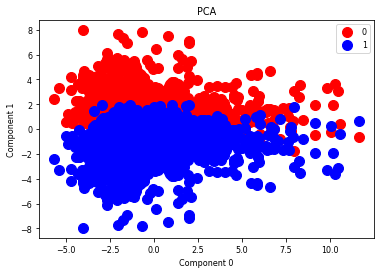

In [53]:
from sklearn.decomposition import PCA

# Fit PCA
pca = PCA(n_components=2)
Z_train = pca.fit_transform(X_train)
print(f"pca.explained_variance_ratio_ = {pca.explained_variance_ratio_}")

# Plot
color_dict = {0: 'red', 1: 'blue'}
for label in np.unique(y_train):
    ix = np.where(y_train == label)
    plt.scatter(Z_train[ix, 0], Z_train[ix, 1], c = color_dict[label], label = label, s = 100)
plt.legend()
plt.title("PCA")
plt.xlabel("Component 0")
plt.ylabel("Component 1")

Text(0.5, 1.0, 'Component 0')

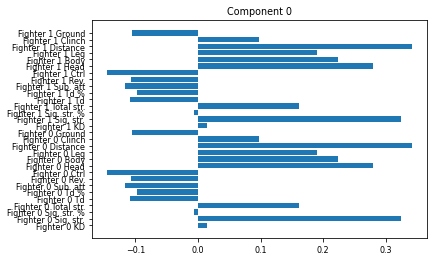

In [54]:
# Understand basis
component0 = pca.components_[0, :]
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
plt.barh(X_train.columns, component0)
plt.title("Component 0")

Text(0.5, 1.0, 'Component 1')

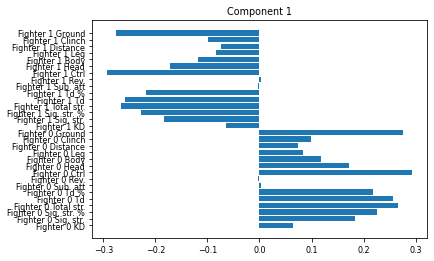

In [55]:
# Understand basis
component1 = pca.components_[1, :]
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
plt.barh(X_train.columns, component1)
plt.title("Component 1")

### Sparse PCA

Text(0, 0.5, 'Component 1')

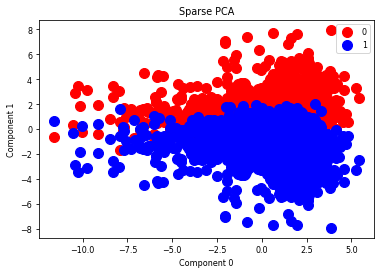

In [56]:
from sklearn.decomposition import SparsePCA

# Fit SparsePCA
sparse_pca = SparsePCA(n_components=2)
Z_train = sparse_pca.fit_transform(X_train)

# Plot
color_dict = {0: 'red', 1: 'blue'}
for label in np.unique(y_train):
    ix = np.where(y_train == label)
    plt.scatter(Z_train[ix, 0], Z_train[ix, 1], c = color_dict[label], label = label, s = 100)
plt.legend()
plt.title("Sparse PCA")
plt.xlabel("Component 0")
plt.ylabel("Component 1")

Text(0.5, 1.0, 'Component 0')

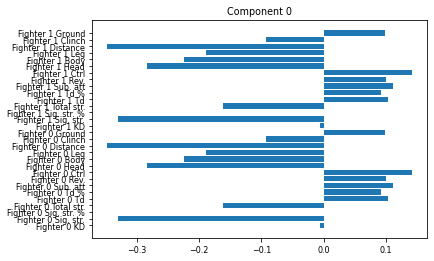

In [57]:
# Understand basis
component0 = sparse_pca.components_[0, :]
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
plt.barh(X_train.columns, component0)
plt.title("Component 0")

Text(0.5, 1.0, 'Component 1')

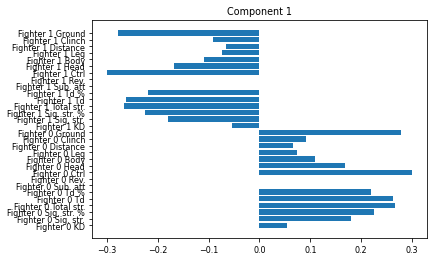

In [58]:
# Understand basis
component1 = sparse_pca.components_[1, :]
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
plt.barh(X_train.columns, component1)
plt.title("Component 1")

### NMF

Text(0, 0.5, 'Component 1')

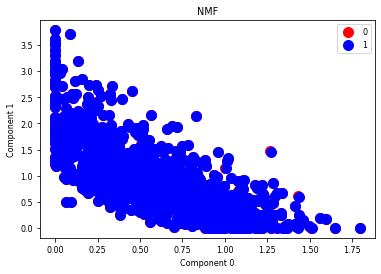

In [67]:
from sklearn.decomposition import NMF

# Fit NMF
nmf = NMF(n_components=2, init='random', random_state=0)
if (X_train < 0).values.any():  # Must be non-negative
    Z_train = nmf.fit_transform(X_train - X_train.min())
else:
    Z_train = nmf.fit_transform(X_train)

# Plot
color_dict = {0: 'red', 1: 'blue'}
for label in np.unique(y_train):
    ix = np.where(y_train == label)
    plt.scatter(Z_train[ix, 0], Z_train[ix, 1], c = color_dict[label], label = label, s = 100)
plt.legend()
plt.title("NMF")
plt.xlabel("Component 0")
plt.ylabel("Component 1")

Text(0.5, 1.0, 'Component 0')

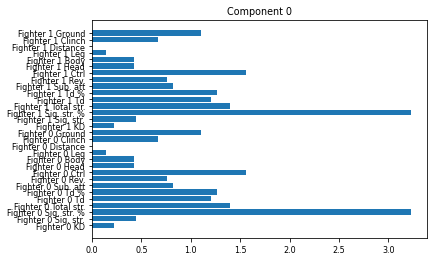

In [68]:
# Understand basis
component0 = nmf.components_[0, :]
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
plt.barh(X_train.columns, component0)
plt.title("Component 0")

Text(0.5, 1.0, 'Component 1')

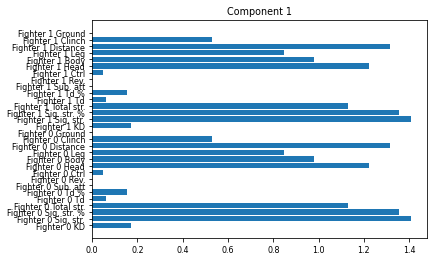

In [69]:
# Understand basis
component1 = nmf.components_[1, :]
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
plt.barh(X_train.columns, component1)
plt.title("Component 1")

### MDS

Text(0, 0.5, 'Component 1')

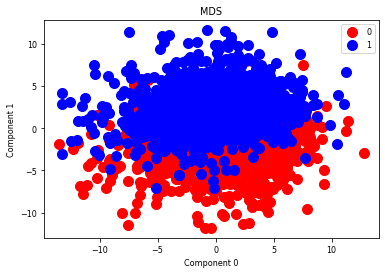

In [70]:
from sklearn.manifold import MDS

# Fit MDS
mds = MDS(n_components=2, random_state=0)
Z_train = mds.fit_transform(X_train)

# Plot
color_dict = {0: 'red', 1: 'blue'}
for label in np.unique(y_train):
    ix = np.where(y_train == label)
    plt.scatter(Z_train[ix, 0], Z_train[ix, 1], c = color_dict[label], label = label, s = 100)
plt.legend()
plt.title("MDS")
plt.xlabel("Component 0")
plt.ylabel("Component 1")

### TSNE

Text(0, 0.5, 'Component 1')

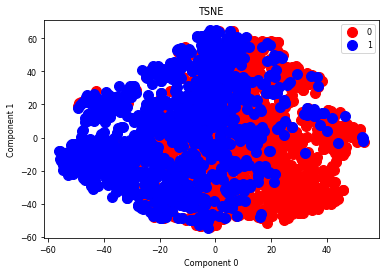

In [71]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
Z_train = tsne.fit_transform(X_train)

# Plot
color_dict = {0: 'red', 1: 'blue'}
for label in np.unique(y_train):
    ix = np.where(y_train == label)
    plt.scatter(Z_train[ix, 0], Z_train[ix, 1], c = color_dict[label], label = label, s = 100)
plt.legend()
plt.title("TSNE")
plt.xlabel("Component 0")
plt.ylabel("Component 1")

### Helper functions for evaluation

In [72]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def get_predIdxs_and_trueIdxs(classifier, X, y):
    predIdxs = np.where(classifier.predict(X) > 0.5, 1, 0)
    trueIdxs = y
    return predIdxs, trueIdxs

def plot_confusion_matrix(classifier, X, y):
    predIdxs, trueIdxs = get_predIdxs_and_trueIdxs(classifier, X, y)
    cm = confusion_matrix(trueIdxs, predIdxs)
    cmDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fighter 0 Win", "Fighter 1 Win"])
    cmDisplay.plot()
    
def print_classification_report(classifier, X, y):
    predIdxs, trueIdxs = get_predIdxs_and_trueIdxs(classifier, X, y)
    print(classification_report(trueIdxs, predIdxs, target_names=["Fighter 0 Win", "Fighter 1 Win"]))

### Decision Tree

accuracy_train = 1.0
accuracy_valid = 0.7609427609427609


<BarContainer object of 30 artists>

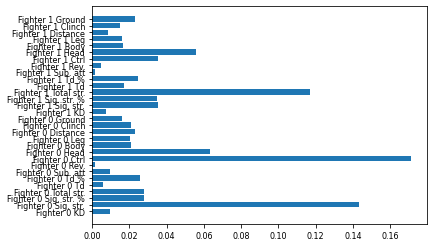

In [90]:
from sklearn.tree import DecisionTreeClassifier
# Train
decision_tree_clf = DecisionTreeClassifier(random_state=0)
decision_tree_clf.fit(X_train, y_train)

# Validate
accuracy_train = decision_tree_clf.score(X_train, y_train)
accuracy_valid = decision_tree_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

# Visualize importances
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
plt.barh(X_train.columns, decision_tree_clf.feature_importances_)

               precision    recall  f1-score   support

Fighter 0 Win       0.77      0.74      0.76       594
Fighter 1 Win       0.75      0.78      0.76       594

     accuracy                           0.76      1188
    macro avg       0.76      0.76      0.76      1188
 weighted avg       0.76      0.76      0.76      1188



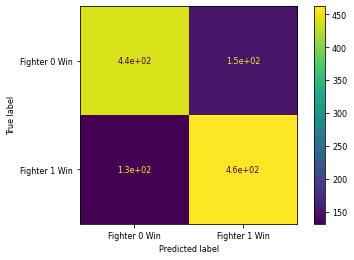

In [91]:
plot_confusion_matrix(decision_tree_clf, X_valid, y_valid)
print_classification_report(decision_tree_clf, X_valid, y_valid)

### Random forest

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


accuracy_train = 0.8924418604651163
accuracy_valid = 0.8442760942760943


<BarContainer object of 30 artists>

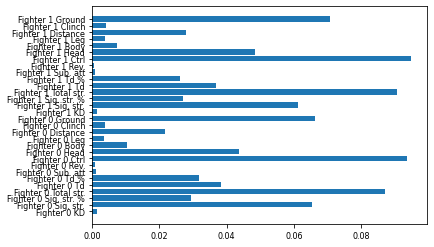

In [92]:
from sklearn.ensemble import RandomForestClassifier

# Train
random_forest_clf = RandomForestClassifier(max_depth=5, random_state=0)
random_forest_clf.fit(X_train, y_train)

# Validate
accuracy_train = random_forest_clf.score(X_train, y_train)
accuracy_valid = random_forest_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

# Visualize importances
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
plt.barh(X_train.columns, random_forest_clf.feature_importances_)

               precision    recall  f1-score   support

Fighter 0 Win       0.84      0.85      0.84       594
Fighter 1 Win       0.84      0.84      0.84       594

     accuracy                           0.84      1188
    macro avg       0.84      0.84      0.84      1188
 weighted avg       0.84      0.84      0.84      1188



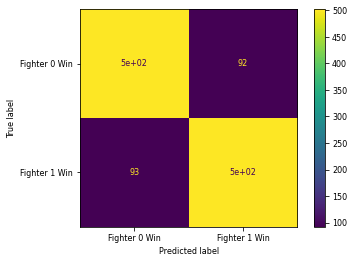

In [93]:
plot_confusion_matrix(random_forest_clf, X_valid, y_valid)
print_classification_report(random_forest_clf, X_valid, y_valid)

### Extra trees

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


accuracy_train = 1.0
accuracy_valid = 0.8417508417508418


<BarContainer object of 30 artists>

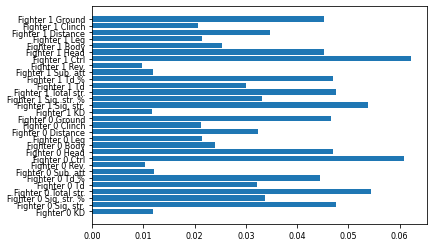

In [94]:
from sklearn.ensemble import ExtraTreesClassifier

# Train
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
extra_trees_clf.fit(X_train, y_train)

# Validate
accuracy_train = extra_trees_clf.score(X_train, y_train)
accuracy_valid = extra_trees_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

# Visualize importances
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
plt.barh(X_train.columns, extra_trees_clf.feature_importances_)

               precision    recall  f1-score   support

Fighter 0 Win       0.84      0.84      0.84       594
Fighter 1 Win       0.84      0.84      0.84       594

     accuracy                           0.84      1188
    macro avg       0.84      0.84      0.84      1188
 weighted avg       0.84      0.84      0.84      1188



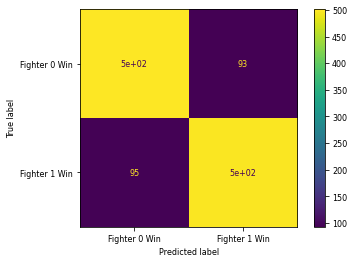

In [95]:
plot_confusion_matrix(extra_trees_clf, X_valid, y_valid)
print_classification_report(extra_trees_clf, X_valid, y_valid)

### MLP

In [96]:
# MLP
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
accuracy_train = mlp_clf.score(X_train, y_train)
accuracy_valid = mlp_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy_train = 0.9431063122923588
accuracy_valid = 0.8367003367003367


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


               precision    recall  f1-score   support

Fighter 0 Win       0.84      0.83      0.84       594
Fighter 1 Win       0.83      0.85      0.84       594

     accuracy                           0.84      1188
    macro avg       0.84      0.84      0.84      1188
 weighted avg       0.84      0.84      0.84      1188



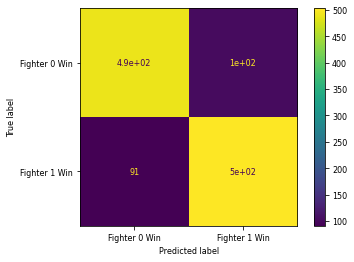

In [97]:
plot_confusion_matrix(mlp_clf, X_valid, y_valid)
print_classification_report(mlp_clf, X_valid, y_valid)

### SVM

In [98]:
# SVM
from sklearn.svm import SVC

svm_clf = SVC(random_state=1).fit(X_train, y_train)
accuracy_train = svm_clf.score(X_train, y_train)
accuracy_valid = svm_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy_train = 0.8870431893687708
accuracy_valid = 0.867003367003367


               precision    recall  f1-score   support

Fighter 0 Win       0.87      0.87      0.87       594
Fighter 1 Win       0.87      0.87      0.87       594

     accuracy                           0.87      1188
    macro avg       0.87      0.87      0.87      1188
 weighted avg       0.87      0.87      0.87      1188



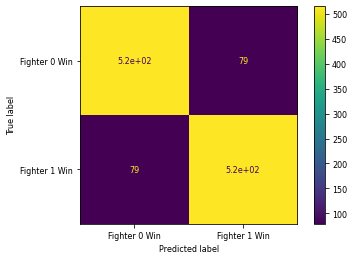

In [99]:
plot_confusion_matrix(svm_clf, X_valid, y_valid)
print_classification_report(svm_clf, X_valid, y_valid)

In [100]:
# SVM linear kernel
svm_linear_clf = SVC(kernel='linear', random_state=1).fit(X_train, y_train)
accuracy_train = svm_linear_clf.score(X_train, y_train)
accuracy_valid = svm_linear_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy_train = 0.8621262458471761
accuracy_valid = 0.8585858585858586


<BarContainer object of 30 artists>

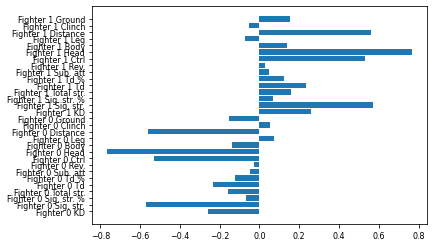

In [101]:
# Visualize importances
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
plt.barh(X_train.columns, svm_linear_clf.coef_[0])

               precision    recall  f1-score   support

Fighter 0 Win       0.86      0.86      0.86       594
Fighter 1 Win       0.86      0.86      0.86       594

     accuracy                           0.86      1188
    macro avg       0.86      0.86      0.86      1188
 weighted avg       0.86      0.86      0.86      1188



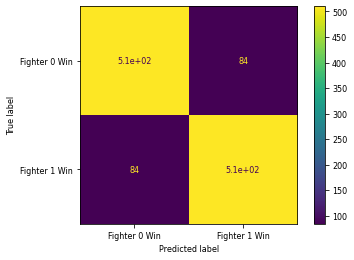

In [102]:
plot_confusion_matrix(svm_linear_clf, X_valid, y_valid)
print_classification_report(svm_linear_clf, X_valid, y_valid)

### XGBoost

In [103]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)

accuracy_train = xgb_clf.score(X_train, y_train)
accuracy_valid = xgb_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy_train = 0.9090531561461794
accuracy_valid = 0.8417508417508418


               precision    recall  f1-score   support

Fighter 0 Win       0.84      0.84      0.84       594
Fighter 1 Win       0.84      0.84      0.84       594

     accuracy                           0.84      1188
    macro avg       0.84      0.84      0.84      1188
 weighted avg       0.84      0.84      0.84      1188



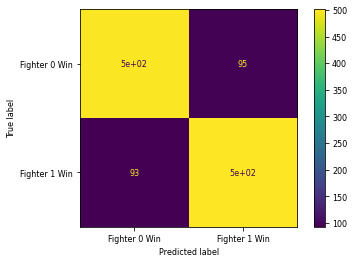

In [104]:
plot_confusion_matrix(xgb_clf, X_valid, y_valid)
print_classification_report(xgb_clf, X_valid, y_valid)

### Logistic regression

In [105]:
from sklearn.linear_model import LogisticRegression
logistic_regression_clf = LogisticRegression(random_state=0).fit(X_train, y_train)

accuracy_train = logistic_regression_clf.score(X_train, y_train)
accuracy_valid = logistic_regression_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

accuracy_train = 0.8662790697674418
accuracy_valid = 0.8569023569023569


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


               precision    recall  f1-score   support

Fighter 0 Win       0.86      0.86      0.86       594
Fighter 1 Win       0.86      0.86      0.86       594

     accuracy                           0.86      1188
    macro avg       0.86      0.86      0.86      1188
 weighted avg       0.86      0.86      0.86      1188



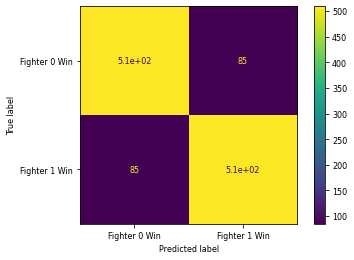

In [106]:
plot_confusion_matrix(logistic_regression_clf, X_valid, y_valid)
print_classification_report(logistic_regression_clf, X_valid, y_valid)

accuracy_train = 0.8662790697674418
accuracy_valid = 0.8569023569023569


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<BarContainer object of 30 artists>

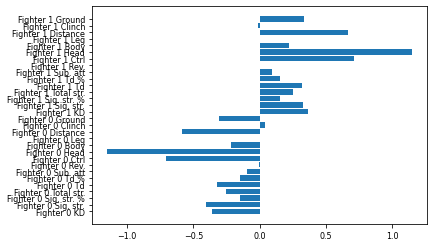

In [107]:
logistic_regression_l1_clf = LogisticRegression(penalty='l1', solver='liblinear', random_state=0).fit(X_train, y_train)

accuracy_train = logistic_regression_l1_clf.score(X_train, y_train)
accuracy_valid = logistic_regression_l1_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

# Visualize importances
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
plt.barh(X_train.columns, logistic_regression_l1_clf.coef_[0])

               precision    recall  f1-score   support

Fighter 0 Win       0.86      0.86      0.86       594
Fighter 1 Win       0.86      0.86      0.86       594

     accuracy                           0.86      1188
    macro avg       0.86      0.86      0.86      1188
 weighted avg       0.86      0.86      0.86      1188



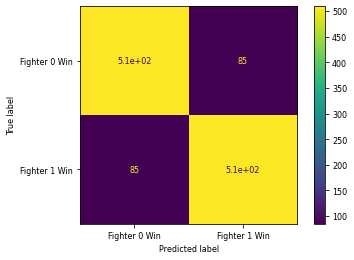

In [108]:
plot_confusion_matrix(logistic_regression_l1_clf, X_valid, y_valid)
print_classification_report(logistic_regression_l1_clf, X_valid, y_valid)

### KNN classifier

In [109]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train)

accuracy_train = knn_clf.score(X_train, y_train)
accuracy_valid = knn_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


accuracy_train = 0.8392857142857143
accuracy_valid = 0.8476430976430976


               precision    recall  f1-score   support

Fighter 0 Win       0.83      0.88      0.85       594
Fighter 1 Win       0.87      0.81      0.84       594

     accuracy                           0.85      1188
    macro avg       0.85      0.85      0.85      1188
 weighted avg       0.85      0.85      0.85      1188



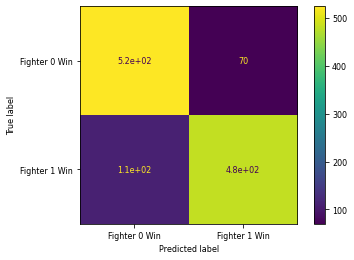

In [110]:
plot_confusion_matrix(knn_clf, X_valid, y_valid)
print_classification_report(knn_clf, X_valid, y_valid)

### Gradient boosting

In [111]:
from sklearn.ensemble import GradientBoostingClassifier
gradient_boosting_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)

accuracy_train = gradient_boosting_clf.score(X_train, y_train)
accuracy_valid = gradient_boosting_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy_train = 0.8799833887043189
accuracy_valid = 0.8232323232323232


               precision    recall  f1-score   support

Fighter 0 Win       0.82      0.82      0.82       594
Fighter 1 Win       0.82      0.82      0.82       594

     accuracy                           0.82      1188
    macro avg       0.82      0.82      0.82      1188
 weighted avg       0.82      0.82      0.82      1188



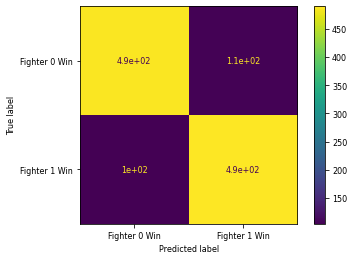

In [112]:
plot_confusion_matrix(gradient_boosting_clf, X_valid, y_valid)
print_classification_report(gradient_boosting_clf, X_valid, y_valid)

### Adaboost

In [113]:
from sklearn.ensemble import AdaBoostClassifier
adaboost_clf = AdaBoostClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)

accuracy_train = adaboost_clf.score(X_train, y_train)
accuracy_valid = adaboost_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy_train = 0.8700166112956811
accuracy_valid = 0.8181818181818182


               precision    recall  f1-score   support

Fighter 0 Win       0.82      0.82      0.82       594
Fighter 1 Win       0.82      0.82      0.82       594

     accuracy                           0.82      1188
    macro avg       0.82      0.82      0.82      1188
 weighted avg       0.82      0.82      0.82      1188



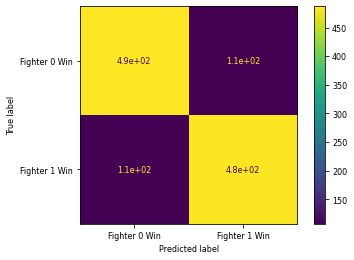

In [114]:
plot_confusion_matrix(adaboost_clf, X_valid, y_valid)
print_classification_report(adaboost_clf, X_valid, y_valid)

### Deep model

In [115]:
# FFN
import tensorflow as tf

deep_model = tf.keras.models.Sequential()
deep_model.add(tf.keras.Input(shape=X_train.shape[1:]))
deep_model.add(tf.keras.layers.Dense(16, activation='relu'))
deep_model.add(tf.keras.layers.Dense(16, activation='relu'))
deep_model.add(tf.keras.layers.Dropout(0.5))
deep_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

deep_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
deep_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                496       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 785
Trainable params: 785
Non-trainable params: 0
_________________________________________________________________


In [116]:
H = deep_model.fit(X_train, y_train, epochs=100, validation_data=(X_valid_new_normal, y_valid))

Epoch 1/100
76/76 [==============================] - 2s 9ms/step - loss: 0.6702 - accuracy: 0.5877 - val_loss: 0.5245 - val_accuracy: 0.8199
Epoch 2/100
76/76 [==============================] - 0s 3ms/step - loss: 0.5344 - accuracy: 0.7398 - val_loss: 0.4121 - val_accuracy: 0.8300
Epoch 3/100
76/76 [==============================] - 0s 2ms/step - loss: 0.4407 - accuracy: 0.8036 - val_loss: 0.3671 - val_accuracy: 0.8384
Epoch 4/100
76/76 [==============================] - 0s 3ms/step - loss: 0.4048 - accuracy: 0.8059 - val_loss: 0.3529 - val_accuracy: 0.8409
Epoch 5/100
76/76 [==============================] - 0s 2ms/step - loss: 0.3897 - accuracy: 0.8336 - val_loss: 0.3462 - val_accuracy: 0.8460
Epoch 6/100
76/76 [==============================] - 0s 3ms/step - loss: 0.3773 - accuracy: 0.8335 - val_loss: 0.3435 - val_accuracy: 0.8476
Epoch 7/100
76/76 [==============================] - 0s 3ms/step - loss: 0.3672 - accuracy: 0.8498 - val_loss: 0.3422 - val_accuracy: 0.8527
Epoch 8/100
7

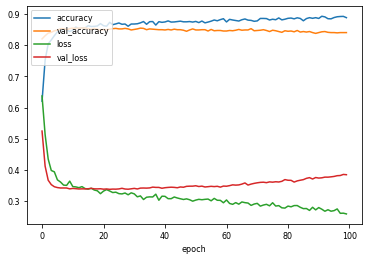

In [117]:
from matplotlib import pyplot as plt
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'], loc='upper left')
plt.show()

               precision    recall  f1-score   support

Fighter 0 Win       0.83      0.86      0.84       594
Fighter 1 Win       0.85      0.82      0.84       594

     accuracy                           0.84      1188
    macro avg       0.84      0.84      0.84      1188
 weighted avg       0.84      0.84      0.84      1188



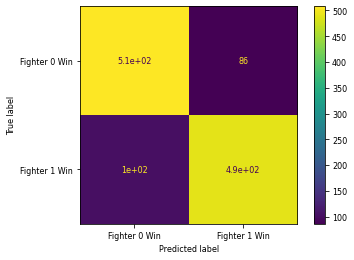

In [118]:
plot_confusion_matrix(deep_model, X_valid_new_normal, y_valid)
print_classification_report(deep_model, X_valid_new_normal, y_valid)

### Comparison Model

In [119]:
from tensorflow.keras.layers import Input, Lambda, Subtract, Activation
from tensorflow.keras.models import Model
def create_comparison_model(input_shape):
    num_features_per_fighter = input_shape[0] // 2

    model_ = tf.keras.models.Sequential()
    model_.add(tf.keras.Input(shape=num_features_per_fighter))
    model_.add(tf.keras.layers.Dense(32, activation='relu'))
    model_.add(tf.keras.layers.Dense(32, activation='relu'))
    model_.add(tf.keras.layers.Dropout(0.5))

    model_.add(tf.keras.layers.Dense(1, activation='relu'))
    
    # Run cnn model on each frame
    input_tensor = Input(shape=input_shape)
    fighter0_state = Lambda(lambda x: x[:, :num_features_per_fighter], name='fighter0_state')(input_tensor)
    fighter1_state = Lambda(lambda x: x[:, num_features_per_fighter:], name='fighter1_state')(input_tensor)

    fighter0_score = model_(fighter0_state)
    fighter1_score = model_(fighter1_state)
    fighter0_score = Lambda(lambda x: x, name='fighter0_score')(fighter0_score)
    fighter1_score = Lambda(lambda x: x, name='fighter1_score')(fighter1_score)
    
    difference_score = Subtract(name='subtracter')([fighter1_score, fighter0_score])
    prediction = Activation('sigmoid')(difference_score)
    return Model(inputs=input_tensor, outputs=prediction)

In [120]:
comparison_model = create_comparison_model(X_train.shape[1:])
optimizer = tf.keras.optimizers.Adam(lr=0.001)
comparison_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
comparison_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
fighter1_state (Lambda)         (None, 15)           0           input_3[0][0]                    
__________________________________________________________________________________________________
fighter0_state (Lambda)         (None, 15)           0           input_3[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1)            1601        fighter0_state[0][0]             
                                                                 fighter1_state[0][0]         

In [121]:
H = comparison_model.fit(X_train, y_train, epochs=100, validation_data=(X_valid_new_normal, y_valid))

Epoch 1/100
76/76 [==============================] - 1s 6ms/step - loss: 0.6009 - accuracy: 0.6443 - val_loss: 0.4434 - val_accuracy: 0.7946
Epoch 2/100
76/76 [==============================] - 0s 3ms/step - loss: 0.4587 - accuracy: 0.7730 - val_loss: 0.3934 - val_accuracy: 0.8266
Epoch 3/100
76/76 [==============================] - 0s 3ms/step - loss: 0.4130 - accuracy: 0.8105 - val_loss: 0.3863 - val_accuracy: 0.8375
Epoch 4/100
76/76 [==============================] - 0s 3ms/step - loss: 0.3891 - accuracy: 0.8130 - val_loss: 0.3784 - val_accuracy: 0.8468
Epoch 5/100
76/76 [==============================] - 0s 3ms/step - loss: 0.3865 - accuracy: 0.8205 - val_loss: 0.3744 - val_accuracy: 0.8485
Epoch 6/100
76/76 [==============================] - 0s 3ms/step - loss: 0.3839 - accuracy: 0.8297 - val_loss: 0.3723 - val_accuracy: 0.8510
Epoch 7/100
76/76 [==============================] - 0s 3ms/step - loss: 0.3558 - accuracy: 0.8414 - val_loss: 0.3696 - val_accuracy: 0.8519
Epoch 8/100
7

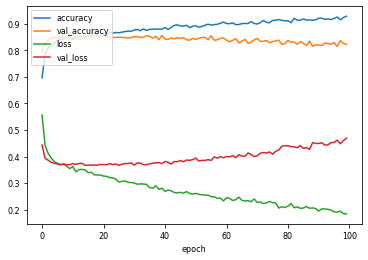

In [122]:
from matplotlib import pyplot as plt
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'], loc='upper left')
plt.show()

               precision    recall  f1-score   support

Fighter 0 Win       0.81      0.84      0.82       594
Fighter 1 Win       0.83      0.81      0.82       594

     accuracy                           0.82      1188
    macro avg       0.82      0.82      0.82      1188
 weighted avg       0.82      0.82      0.82      1188



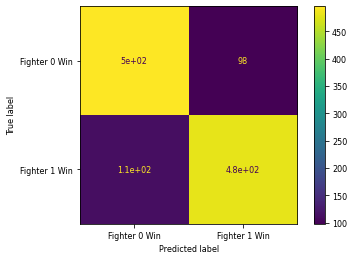

In [123]:
plot_confusion_matrix(comparison_model, X_valid_new_normal, y_valid)
print_classification_report(comparison_model, X_valid_new_normal, y_valid)

In [124]:
lo, hi = 11, 20

In [125]:
X_test_new[lo:hi]

,Fighter 0 KD,Fighter 0 Sig. str.,Fighter 0 Sig. str. %,Fighter 0 Total str.,Fighter 0 Td,Fighter 0 Td %,Fighter 0 Sub. att,Fighter 0 Rev.,Fighter 0 Ctrl,Fighter 0 Head,Fighter 0 Body,Fighter 0 Leg,Fighter 0 Distance,Fighter 0 Clinch,Fighter 0 Ground,Fighter 1 KD,Fighter 1 Sig. str.,Fighter 1 Sig. str. %,Fighter 1 Total str.,Fighter 1 Td,Fighter 1 Td %,Fighter 1 Sub. att,Fighter 1 Rev.,Fighter 1 Ctrl,Fighter 1 Head,Fighter 1 Body,Fighter 1 Leg,Fighter 1 Distance,Fighter 1 Clinch,Fighter 1 Ground
1705,0,63,45.0,84,1,100.0,0,0,280.0,40,18,5,41,9,13,0,34,42.0,61,1,20.0,0,0,146.0,18,8,8,26,3,5
1058,0,77,44.0,125,0,0.0,0,0,0.0,29,28,20,65,8,4,1,67,43.0,91,0,0.0,0,0,278.0,21,31,15,54,8,5
619,0,134,44.0,135,0,0.0,0,0,2.0,85,32,17,132,2,0,0,157,51.0,157,0,0.0,0,0,45.0,67,15,75,156,1,0
3465,0,16,34.0,51,2,50.0,3,0,521.0,10,4,2,7,3,6,0,19,26.0,44,0,0.0,0,1,14.0,14,2,3,19,0,0
5609,0,88,47.0,96,2,22.0,1,0,154.0,62,16,10,51,33,4,0,57,38.0,64,0,0.0,0,0,19.0,55,1,1,43,14,0
2047,0,20,50.0,83,2,33.0,0,0,744.0,12,7,1,4,6,10,0,11,36.0,28,0,0.0,0,1,40.0,5,4,2,6,5,0
2097,0,61,36.0,68,2,40.0,0,0,52.0,39,6,16,57,3,1,0,82,38.0,99,0,0.0,0,1,178.0,55,15,12,75,5,2
251,0,20,27.0,29,5,45.0,0,0,416.0,7,2,11,18,2,0,0,47,52.0,54,1,20.0,0,2,72.0,34,4,9,35,6,6
965,0,53,62.0,95,2,50.0,0,0,551.0,41,7,5,31,3,19,0,30,42.0,86,1,100.0,0,0,101.0,16,5,9,24,4,2


In [126]:
X_test_new_normal[lo:hi]

,Fighter 0 KD,Fighter 0 Sig. str.,Fighter 0 Sig. str. %,Fighter 0 Total str.,Fighter 0 Td,Fighter 0 Td %,Fighter 0 Sub. att,Fighter 0 Rev.,Fighter 0 Ctrl,Fighter 0 Head,Fighter 0 Body,Fighter 0 Leg,Fighter 0 Distance,Fighter 0 Clinch,Fighter 0 Ground,Fighter 1 KD,Fighter 1 Sig. str.,Fighter 1 Sig. str. %,Fighter 1 Total str.,Fighter 1 Td,Fighter 1 Td %,Fighter 1 Sub. att,Fighter 1 Rev.,Fighter 1 Ctrl,Fighter 1 Head,Fighter 1 Body,Fighter 1 Leg,Fighter 1 Distance,Fighter 1 Clinch,Fighter 1 Ground
1705,-0.305299,0.451171,0.206558,0.184297,-0.278075,2.083169,-0.430413,-0.384637,0.404103,0.428024,0.877866,-0.370081,0.158757,0.195140,0.802114,-0.305299,-0.501482,-0.032764,-0.392538,-0.278075,-0.303287,-0.430413,-0.384637,-0.247173,-0.575117,-0.252079,-0.045631,-0.353874,-0.500146,-0.064462
1058,-0.305299,0.911072,0.126784,1.212567,-0.768267,-0.899901,-0.430413,-0.384637,-0.956773,-0.073547,2.007812,1.252169,0.978966,0.079259,-0.172784,2.329682,0.582571,0.047010,0.359855,-0.768267,-0.899901,-0.430413,-0.384637,0.394382,-0.438325,2.346795,0.711419,0.603037,0.079259,-0.064462
619,-0.305299,2.783528,0.126784,1.463365,-0.768267,-0.899901,-0.430413,-0.384637,-0.947052,2.479904,2.459790,0.927719,3.268719,-0.616028,-0.606073,-0.305299,3.539080,0.685204,2.015120,-0.768267,-0.899901,-0.430413,-0.384637,-0.738060,1.659152,0.538883,7.200420,4.088928,-0.731909,-0.606073
3465,-0.305299,-1.092784,-0.670959,-0.643336,0.212118,0.591634,2.801714,-0.384637,1.575427,-0.939896,-0.704057,-0.694532,-1.003207,-0.500146,0.043860,-0.305299,-0.994234,-1.309153,-0.818894,-0.768267,-0.899901,-0.430413,1.659969,-0.888729,-0.757506,-0.930046,-0.586382,-0.593102,-0.847790,-0.606073
5609,-0.305299,1.272423,0.366107,0.485254,0.212118,-0.243626,0.646962,-0.384637,-0.208291,1.431165,0.651877,0.170669,0.500511,2.976287,-0.172784,-0.305299,0.254070,-0.351862,-0.317299,-0.768267,-0.899901,-0.430413,-0.384637,-0.864427,1.111984,-1.043041,-0.802682,0.227107,0.774546,-0.606073
2047,-0.305299,-0.961384,0.605430,0.159217,0.212118,0.084512,-0.430413,-0.384637,2.659267,-0.848701,-0.365074,-0.802682,-1.105733,-0.152503,0.477148,-0.305299,-1.257035,-0.511410,-1.220170,-0.768267,-0.899901,-0.430413,1.659969,-0.762362,-1.167882,-0.704057,-0.694532,-1.037383,-0.268384,-0.606073
2097,-0.305299,0.385470,-0.511410,-0.216980,0.212118,0.293327,-0.430413,-0.384637,-0.704039,0.382427,-0.478068,0.819569,0.705563,-0.500146,-0.497751,-0.305299,1.075323,-0.351862,0.560493,-0.768267,-0.899901,-0.430413,1.659969,-0.091645,1.111984,0.538883,0.386969,1.320720,-0.268384,-0.389429
251,-0.305299,-0.961384,-1.229379,-1.195091,1.682697,0.442481,-0.430413,-0.384637,1.065099,-1.076688,-0.930046,0.278819,-0.627278,-0.616028,-0.606073,-0.305299,-0.074431,0.764979,-0.568096,-0.278075,-0.303287,-0.430413,3.704575,-0.606833,0.154440,-0.704057,0.062519,-0.046296,-0.152503,0.043860
965,-0.305299,0.122669,1.562722,0.460174,0.212118,0.591634,-0.430413,-0.384637,1.721235,0.473621,-0.365074,-0.370081,-0.182997,-0.500146,1.452046,-0.305299,-0.632883,-0.032764,0.234456,-0.278075,2.083169,-0.430413,-0.384637,-0.465885,-0.666312,-0.591063,0.062519,-0.422225,-0.384265,-0.389429


In [127]:
comparison_model.predict(X_test_new_normal[lo:hi])

array([[0.00329462],
       [0.75149965],
       [0.9184923 ],
       [0.01329359],
       [0.10502091],
       [0.02410832],
       [0.89656585],
       [0.7500739 ],
       [0.00354725]], dtype=float32)

In [128]:
y_test[lo:hi]

,Winner
1705,0
1058,1
619,1
3465,0
5609,0
2047,0
2097,1
251,1
965,0


In [129]:
subtracter = comparison_model.get_layer('subtracter').output
subtracter = Model(comparison_model.input, subtracter)
subtracter.predict(X_test_new_normal[lo:hi])

array([[-5.7121534],
       [ 1.1066265],
       [ 2.4220362],
       [-4.307089 ],
       [-2.1426406],
       [-3.7007952],
       [ 2.1596367],
       [ 1.0990064],
       [-5.6380205]], dtype=float32)

In [130]:
fighter0_score = comparison_model.get_layer('fighter0_score').output
fighter0_score = Model(comparison_model.input, fighter0_score)
fighter0_score.predict(X_test_new_normal[lo:hi])

array([[6.160447 ],
       [3.1776943],
       [9.627033 ],
       [4.307089 ],
       [5.838058 ],
       [3.7007952],
       [3.1767437],
       [1.3666499],
       [7.308317 ]], dtype=float32)

In [131]:
fighter1_score = comparison_model.get_layer('fighter1_score').output
fighter1_score = Model(comparison_model.input, fighter1_score)
fighter1_score.predict(X_test_new_normal[lo:hi])

array([[ 0.4482937],
       [ 4.284321 ],
       [12.049069 ],
       [ 0.       ],
       [ 3.6954174],
       [ 0.       ],
       [ 5.3363805],
       [ 2.4656563],
       [ 1.6702965]], dtype=float32)

In [132]:
columns = list(X_test_new_normal.columns)
new_columns = columns[len(columns)//2:] + columns[:len(columns)//2]
switcheroo = X_test_new_normal[new_columns]
fighter1_score.predict(switcheroo[lo:hi])

array([[6.160447 ],
       [3.1776943],
       [9.627033 ],
       [4.307089 ],
       [5.838058 ],
       [3.7007952],
       [3.1767437],
       [1.3666499],
       [7.308317 ]], dtype=float32)

In [133]:
fighter0_score.predict(switcheroo[lo:hi])

array([[ 0.4482937],
       [ 4.284321 ],
       [12.049069 ],
       [ 0.       ],
       [ 3.6954174],
       [ 0.       ],
       [ 5.3363805],
       [ 2.4656563],
       [ 1.6702965]], dtype=float32)

In [134]:
subtracter.predict(switcheroo[lo:hi])

array([[ 5.7121534],
       [-1.1066265],
       [-2.4220362],
       [ 4.307089 ],
       [ 2.1426406],
       [ 3.7007952],
       [-2.1596367],
       [-1.0990064],
       [ 5.6380205]], dtype=float32)

In [135]:
comparison_model.predict(switcheroo[lo:hi])

array([[0.9967054 ],
       [0.24850035],
       [0.08150765],
       [0.9867064 ],
       [0.8949791 ],
       [0.9758917 ],
       [0.10343415],
       [0.24992612],
       [0.99645275]], dtype=float32)

In [136]:
deep_model.predict(X_test_new_normal[1:10])

array([[4.3995985e-01],
       [3.9455116e-02],
       [2.6457876e-02],
       [3.6165178e-01],
       [9.3654847e-01],
       [6.9301963e-02],
       [8.1157243e-01],
       [6.9787711e-06],
       [1.6031101e-01]], dtype=float32)

In [137]:
deep_model.predict(switcheroo[1:10])

array([[0.40210706],
       [0.9359652 ],
       [0.9955026 ],
       [0.34776118],
       [0.07849714],
       [0.99867487],
       [0.28339642],
       [0.999948  ],
       [0.80050206]], dtype=float32)